In [1]:
from ml_functions import get_historical_data

In [2]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [3]:
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use('Agg')
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import warnings

#warnings.filterwarnings("ignore")

In [4]:
coin_df = get_historical_data('BTC', 900 )

In [6]:
coin_df.tail()

,close
Date,
2020-01-09,7817.35
2020-01-10,8190.31
2020-01-11,8024.58
2020-01-12,8181.49
2020-01-13,8125.98


In [7]:
coin_df.to_csv('./Data/BTC_daily_price.csv')

In [6]:
transformed_data, lmda = boxcox(coin_df)


In [7]:
lmda

array([-0.07293045])

In [8]:
transformed_data = transformed_data.flatten().tolist()


In [9]:
transformed_df = coin_df.copy()


In [10]:
transformed_df['close'] = transformed_data


In [11]:
transformed_diff_df = transformed_df.diff().dropna()

In [12]:
transformed_diff_df.head()

,close
Date,
2019-01-09,-0.011891
2019-01-10,-0.114423
2019-01-11,-0.035922
2019-01-12,0.007712
2019-01-13,-0.053467


In [13]:
stationary = adfuller(transformed_diff_df['close'])

In [14]:
stationary[1]

0.0

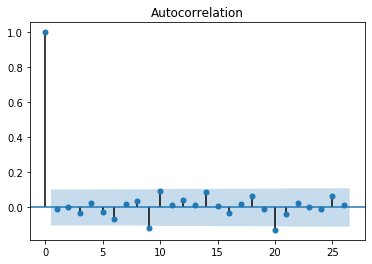

In [15]:
plot_acf(transformed_diff_df)
plt.show()

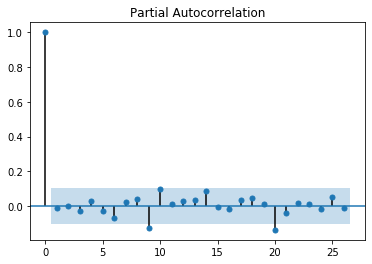

In [16]:
plot_pacf(transformed_diff_df)
plt.show()

seasonal_decompose(transformed_diff_df).plot()
plt.show()

In [30]:
model = SARIMAX(transformed_df, order = ((0,0,0,0,0,0,0,0,1),1,(0,0,0,0,0,0,0,0,0,1)))


C:\Users\willi\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [31]:
model_fit = model.fit(disp = True)


In [32]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              Statespace Model Results                             
===================================================================================
Dep. Variable:                       close   No. Observations:                  366
Model:             SARIMAX((9,), 1, (10,))   Log Likelihood                 698.765
Date:                     Wed, 08 Jan 2020   AIC                          -1391.531
Time:                             12:39:34   BIC                          -1379.831
Sample:                         01-08-2019   HQIC                         -1386.881
                              - 01-08-2020                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L9         -0.1220      0.052     -2.361      0.018      -0.223      -0.021
ma.L10         0.1295      0.055      2.343      0.019       0.021       0.238
sigma2         0.0013   4.84e-05     26.256      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                       29.97   Jarque-Bera (JB):               494.13
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\willi\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


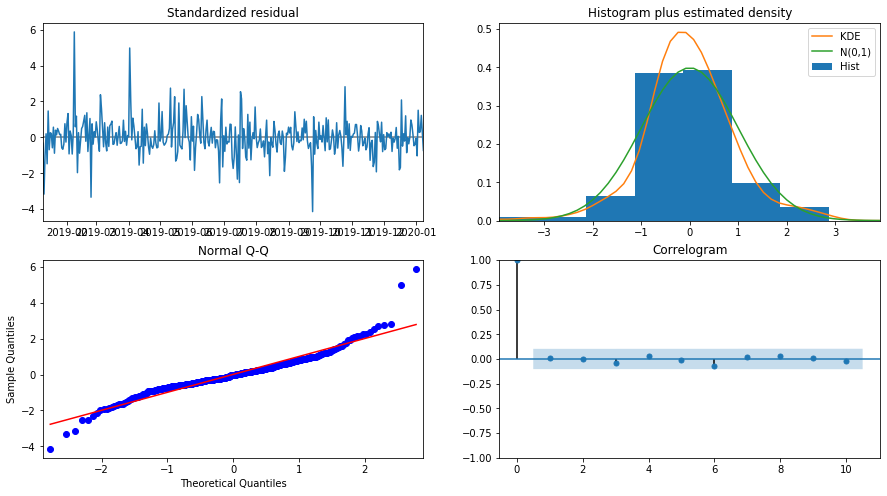

In [33]:
model_fit.plot_diagnostics(figsize=(15,8))
plt.show()


In [34]:
conf_int = model_fit.get_forecast(5)


In [35]:
confidence_intervals = conf_int.conf_int()



In [36]:
confidence_intervals = inv_boxcox(confidence_intervals, lmda)


In [37]:
predictions = model_fit.predict(start= 366, end = 371)


In [38]:
predicted_close = inv_boxcox(predictions, lmda)


In [39]:
predicted_close.head()

2020-01-09    45.125792
2020-01-10    44.970033
2020-01-11    45.247488
2020-01-12    44.572304
2020-01-13    44.924376
Freq: D, dtype: float64

In [40]:
forecast_df = confidence_intervals.copy()


In [41]:
forecast_df['predicted_close'] = predicted_close


In [43]:
forecast_df = forecast_df.round(2)


In [44]:
forecast_df.head()

,lower close,upper close,predicted_close
2020-01-09,41.16,49.50,45.13
2020-01-10,39.49,51.27,44.97
2020-01-11,38.60,53.14,45.25
2020-01-12,37.11,53.66,44.57
2020-01-13,36.61,55.30,44.92


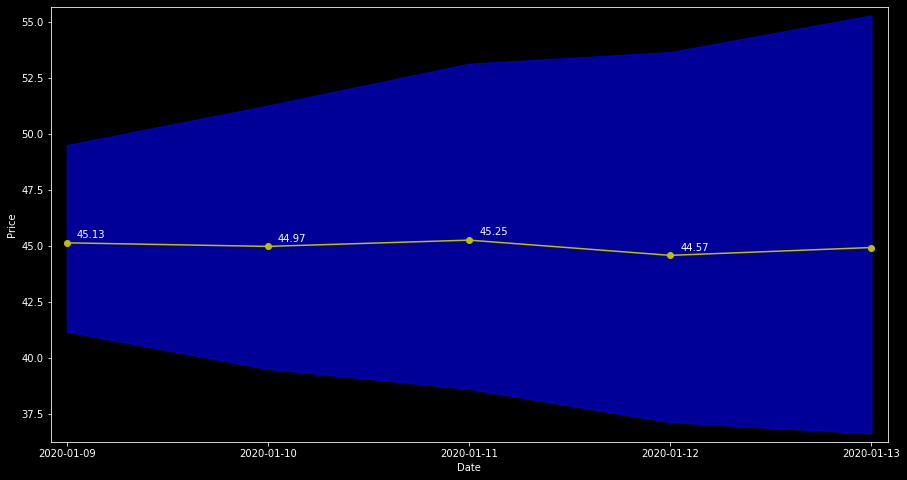

In [45]:
plt.style.use('dark_background')
fig = plt.figure(figsize = (15,8))
plt.plot(forecast_df['predicted_close'], marker = 'o', color = 'y')
plt.fill_between(forecast_df.index, forecast_df['lower close'],forecast_df['upper close'], color = 'b', alpha = 0.6)
plt.ylabel('Price')
plt.xlabel('Date')
plt.margins(0.02)
plt.xticks(forecast_df.index)
for i,j in zip(forecast_df.index[0:4], forecast_df['predicted_close'][0:4]):
    plt.annotate(str(j),xy=(i,j), xytext = (10,5), textcoords= 'offset points')
plt.show()

In [52]:
combined_df = coin_df.copy()

In [53]:
combined_df['predicted_close'] = predicted_close

In [54]:
combined_df = combined_df.round(2).dropna()

In [55]:
combined_df.head()

,close,predicted_close
Date,,


In [50]:
combined_df[340:365].plot()


TypeError: no numeric data to plot

In [ ]:
days_previous_dict = {'BTC': 730, 'ETH': 365}


In [ ]:
days_previous_dict['BTC']

In [ ]:
btc_order = (0,0,0,0,0,0,0,0,1,0,0,0,0,1),1,(1,0,1,1,1)